<a href="https://colab.research.google.com/github/Spinal-Tap369/lstm_stock_price_pred/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

First thing, import dependencies!

In [ ]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import torch.utils.data as data_utils

# Data Loading

The dataset is loaded from a CSV file using pandas. This dataset contains historical stock price data, including features like Open, High, Low, Close, Volume, etc.

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1dc18iHH2-nGvTeIvrvhBzkfrOb-EBJ_2")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VWAP
0,03-01-2000,15.422222,15.744444,15.000000,15.744444,9.526704,25322175.0,15.496296
1,04-01-2000,15.866666,16.200001,15.428888,15.830000,9.578474,32068665.0,15.81962967
2,05-01-2000,15.916666,16.864445,14.666666,16.137777,9.764706,62196705.0,15.88962933
3,06-01-2000,16.466665,17.428888,16.466665,17.428888,10.545935,32472810.0,17.108147
4,07-01-2000,18.497778,18.823334,18.311111,18.823334,11.389690,10404405.0,18.652593


## Data Pre Processing

We will convert the date format and set the column as the index

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)

Now lets calculate and append technical indicators like Moving Average (MA), Relative Strength Index (RSI), and Daily Returns.

In [ ]:
def compute_rsi(data, window):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    rsi[:window] = np.nan  # RSI is not defined for the initial window period

    return rsi

In [ ]:
# Compute MA, RSI, and Daily Returns
df['MA'] = df['Close'].rolling(window=14).mean()
df['RSI'] = compute_rsi(df['Close'], window=14)
df['Daily_Returns'] = df['Close'].pct_change()
df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP,MA,RSI,Daily_Returns
Date,,,,,,,,,,
2000-01-03,15.422222,15.744444,15.000000,15.744444,9.526704,25322175.0,15.496296,NaN,NaN,NaN
2000-01-04,15.866666,16.200001,15.428888,15.830000,9.578474,32068665.0,15.81962967,NaN,NaN,0.005434
2000-01-05,15.916666,16.864445,14.666666,16.137777,9.764706,62196705.0,15.88962933,NaN,NaN,0.019443
2000-01-06,16.466665,17.428888,16.466665,17.428888,10.545935,32472810.0,17.108147,NaN,NaN,0.080006
2000-01-07,18.497778,18.823334,18.311111,18.823334,11.389690,10404405.0,18.652593,NaN,NaN,0.080008


Rows containing NaN values resulting from the computation are dropped.

In [ ]:
df.dropna(inplace=True)
df.count()

Open             5705
High             5705
Low              5705
Close            5705
Adj Close        5705
Volume           5705
VWAP             5705
MA               5705
RSI              5705
Daily_Returns    5705
dtype: int64

Create the 'Target' column indicating if the stock price went up or down

In [ ]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP,MA,RSI,Daily_Returns,Target
Date,,,,,,,,,,,
2000-01-21,17.444445,18.797777,17.444445,18.478888,11.181273,54041490.0,18.24037,18.423095,64.546626,0.057817,0
2000-01-24,18.577778,19.066666,17.388887,17.610001,10.655521,69614775.0,18.02185133,18.550238,58.740727,-0.047021,0
2000-01-25,17.333332,17.333332,16.201111,16.212221,9.809747,55845675.0,16.58222133,18.555555,50.330210,-0.079374,0
2000-01-26,16.212221,16.212221,16.212221,16.212221,9.809747,0.0,16.212221,18.468650,43.905156,0.000000,1
2000-01-27,16.688889,17.510000,15.111111,17.307777,10.472651,84060675.0,16.64296267,18.360396,42.173510,0.067576,0


Let's visualize the close price as we need to be predicting close price. There is no dicernable pattern other that any old stock chart.

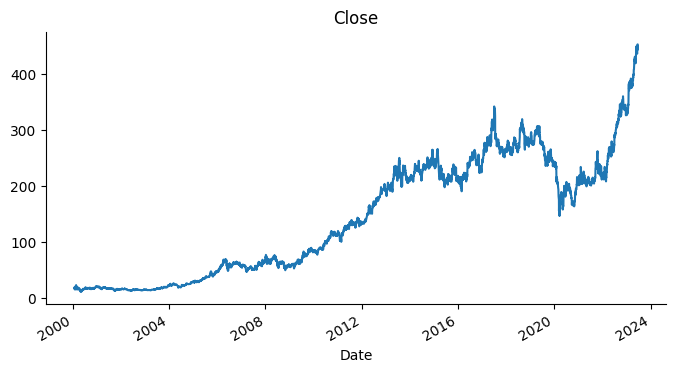

In [ ]:
from matplotlib import pyplot as plt
df['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

# Feature Scaling

Features are scaled using MinMaxScaler. Scaling ensures that all features are on a similar scale, which helps in improving the performance of lstm models.

In [ ]:
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'MA', 'RSI', 'Daily_Returns']
df2 = df.copy()
# Scale the features
scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Creating sequences

* Sequences of input features and corresponding target prices are created.
* Each sequence contains a window of historical data (input features) along with the target price.
* The length of the sequence is a hyperparameter that can be adjusted based on the problem and dataset characteristics.

In [ ]:
def create_sequences(data, target1, sequence_length):
    X = []
    y1 = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y1.append(target1[i])
    return np.array(X), np.array(y1)

# Experiment with different sequence lengths
sequence_length = 60

# Creating sequences
X, y_price = create_sequences(df[features_to_scale].values, df['Close'].values, sequence_length)

# Train test split

The dataset is split into training and testing sets. Typically, a portion of the data (e.g., 80%) is used for training, and the remaining portion is used for testing the model's performance.

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_price_train, y_price_test = y_price[:train_size], y_price[train_size:]

# Converting them into tensors

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_price_train_tensor = torch.tensor(y_price_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_price_test_tensor = torch.tensor(y_price_test, dtype=torch.float32)

In [ ]:
X_train_tensor.shape, y_price_train_tensor.shape

(torch.Size([4516, 60, 9]), torch.Size([4516]))

In [ ]:
X_test_tensor.shape, y_price_test_tensor.shape

(torch.Size([1129, 60, 9]), torch.Size([1129]))

# Create Dataset and Dataloader for training and testing

* PyTorch's Dataset and Dataloader classes are used to create iterable objects for the training and testing data.
* Dataloaders help in efficiently loading and batching the data during training and evaluation, enabling better utilization of computational resources.

In [ ]:
train_dataset = data_utils.TensorDataset(X_train_tensor, y_price_train_tensor)
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = data_utils.TensorDataset(X_test_tensor, y_price_test_tensor)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=32, shuffle=True)

# The model

The StockLSTM class defines a Long Short-Term Memory (LSTM) neural network architecture specifically tailored for stock price prediction. It consists of an LSTM layer followed by a dropout layer for regularization, batch normalization layer for stabilizing training, and a linear layer for predicting stock prices. This architecture allows the model to capture temporal dependencies in the input data and make predictions based on historical price sequences.

In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc_price = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout to the last output
        out = self.bn(out)  # Apply batch normalization

        price = self.fc_price(out)

        return price

# Hyperparameters
input_size = X.shape[2]  # Number of features
hidden_size = 100  # Increased hidden size
num_layers = 3  # Increased number of layers
num_epochs = 1
batch_size = 32
learning_rate = 0.01

# Initialize model, loss fuction and optimizer

Loss function and optimizer are crucial for a Neural Network to train.

In [ ]:
model = StockLSTM(input_size, hidden_size, num_layers).to(device)
criterion_price = nn.MSELoss()
criterion_direction = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Training our model

The training process involves iteratively passing batches of input sequences through the model, computing the Mean Squared Error (MSE) loss between predicted and actual prices, and optimizing the model parameters using the Adam optimizer with weight decay. Additionally, gradient clipping is applied to prevent exploding gradients during training.

In [ ]:
for epoch in range(num_epochs):
    for sequences, prices in train_dataloader:
        sequences = sequences.to(device)
        prices = prices.to(device)

        outputs_price = model(sequences)
        loss_price = criterion_price(outputs_price.squeeze(), prices)


        optimizer.zero_grad()
        loss_price.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()


    print(f'Epoch [{epoch+1}/{num_epochs}], LossMSE: {loss_price.item():.4f}')

Epoch [1/1], LossMSE: 0.0066


# Evaluating our model

After training, the model is evaluated on the test dataset to assess its performance using the MSE loss metric. Finally, the actual and predicted prices are plotted for visual inspection, providing insights into the model's predictive capabilities.

Test Loss: 0.0047


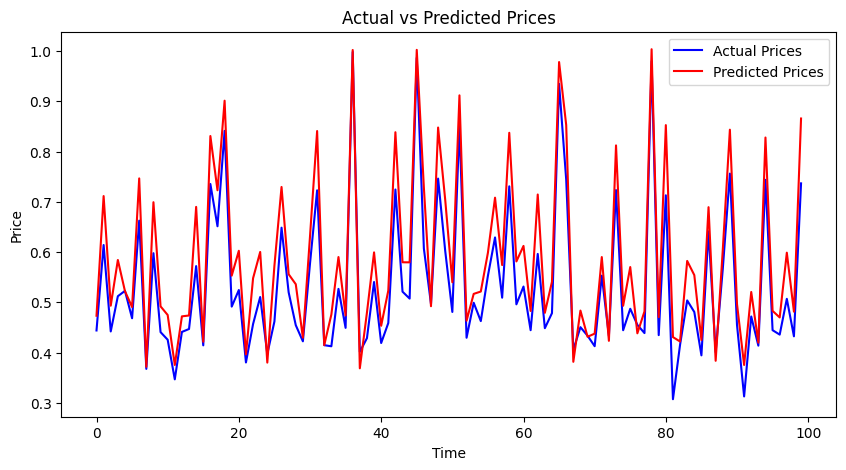

In [ ]:
def evaluate_model(model, criterion_price, test_dataloader):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for sequences, prices in test_dataloader:
            sequences = sequences.to(device)
            prices = prices.to(device)

            outputs_price = model(sequences)
            loss_price = criterion_price(outputs_price.squeeze(), prices)
            test_loss += loss_price.item()

    avg_test_loss = test_loss / len(test_dataloader)
    print(f'Test Loss: {avg_test_loss:.4f}')
    return avg_test_loss

def plot_results(model, test_dataloader, num_samples=100):
    model.eval()
    actual_prices = []
    predicted_prices = []

    with torch.no_grad():
        for sequences, prices in test_dataloader:
            sequences = sequences.to(device)
            prices = prices.to(device)

            outputs_price = model(sequences)
            actual_prices.extend(prices.cpu().numpy())
            predicted_prices.extend(outputs_price.squeeze().cpu().numpy())

    # Plot a subset of the data
    actual_prices = actual_prices[:num_samples]
    predicted_prices = predicted_prices[:num_samples]

    plt.figure(figsize=(10, 5))
    plt.plot(actual_prices, label='Actual Prices', color='blue')
    plt.plot(predicted_prices, label='Predicted Prices', color='red')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Actual vs Predicted Prices')
    plt.legend()
    plt.show()


# Evaluate the model
test_loss = evaluate_model(model, criterion_price, test_dataloader)

# Plot the results
plot_results(model, test_dataloader, num_samples=100)

As seen below, the average loss comes about to be quite low following the L2 loss function

In [ ]:
test_loss = evaluate_model(model, criterion_price, test_dataloader)

Test Loss: 0.0047


# What else can be done (Future Work)

The target column was added to try and predict if the Stock price will be higer or lower than the previous day. Using Classification methods such as NN Classifiers and Random Forest classification, the predictions were atrocious. More work is being done to predict the same